https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html

https://flax.readthedocs.io/en/latest/getting_started.html

# Prepare data

In [1]:
from typing import Sequence, Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

# 2. Loading data

In [2]:
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

def mapping(n, inverse=False):
    mapping_dict = {'피스': 0, '터짐': 1, '곰팡이': 2, '들뜸': 3, '오염': 4, '창틀,문틀수정': 5, '면불량': 6, '걸레받이수정': 7, '몰딩수정': 8, '오타공': 9, '석고수정': 10, '이음부불량': 11, '꼬임': 12, '울음': 13, '틈새과다': 14, '훼손': 15, '가구수정': 16, '반점': 17, '녹오염': 18}
    inverse_mapping = {v: k for k, v in mapping_dict.items()}
    if inverse:
        return inverse_mapping[n]
    return mapping_dict[n]

def imread_and_resize(img_path, size = (224, 224)):
    image = Image.open(img_path)
    image = image.resize((224, 224))
    
    return image

def get_datasets(batch_size = 32):
    img_path_list = glob.glob("../dataset/train/*/*.png")
    img_list = []
    label_list = []
    for path in tqdm(img_path_list):
        img_list.append(imread_and_resize(path))
        label_list.append(mapping(path.split('/')[3]))
    images = jnp.stack([jnp.array(img) for img in img_list])
    labels = jnp.array(label_list)
    images.shape, labels.shape

    from sklearn.model_selection import train_test_split


    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    print(x_train.shape, y_train.shape)

    train_ds = []
    for i in range(np.ceil(x_train.shape[0] / 32).astype(np.int8)):
        batch_start = i * 32
        batch_end = (i+1) * 32
        sub_dict = {
            'image': x_train[batch_start:batch_end], 
            'label': y_train[batch_start:batch_end], 
        }
        train_ds.append(sub_dict)

    test_ds = []
    for i in range(np.ceil(x_test.shape[0] / 32).astype(np.int8)):
        batch_start = i * 32
        batch_end = (i+1) * 32
        sub_dict = {
            'image': x_train[batch_start:batch_end], 
            'label': y_train[batch_start:batch_end], 
        }
        test_ds.append(sub_dict)
    print(len(train_ds), len(test_ds))
    return train_ds, test_ds
train_ds, test_ds = get_datasets()

  0%|          | 0/3457 [00:00<?, ?it/s]

(2765, 224, 224, 3) (2765,)
87 22


# 3. Define network

In [3]:
from flax import linen as nn  # Linen API

# from models import create_efficientnet_v2
# model = create_efficientnet_v2('s', num_classes = 19)

"""
Efficientnet_b0 from https://github.com/rwightman/efficientnet-jax
to use this.
1. git clone repository
2. copy jeffnet directory to here.
"""
from jeffnet.linen import create_model
rng = jax.random.PRNGKey(0)
model, variables = create_model('pt_efficientnet_b0', pretrained=True, rng=rng)

## View model layers

In [5]:
import jax
import jax.numpy as jnp  # JAX NumPy


# print(model.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 224, 224, 3))), training=False)

TypeError: __call__() missing 1 required positional argument: 'training'

# 4. Create a TrainState

In [6]:
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

In [7]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [18]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    batch_stats: Any

def create_train_state(module, rng, learning_rate, momentum):
    """Creates an initial `TrainState`."""
    vars_in = module.init(rng, jnp.ones([1, 224, 224, 3]), training=False) # initialize parameters by passing a template image
#     parm
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(
        apply_fn=module.apply, 
        params=vars_in['params'], 
        batch_stats=vars_in['batch_stats'], 
        tx=tx,
        metrics=Metrics.empty())

# 5. Training step

In [11]:
@jax.jit
def train_step(state: TrainState, batch):
    """Train for a single step."""
    def loss_fn(params):
        logits, updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            x=batch['image'], 
            training=True, 
            mutable=['batch_stats']
        )
        
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
        return loss, (logits, updates)
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, updates)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates['batch_stats'])
    metrics = {
        'train_loss': loss,
        'train_accuracy': jnp.mean(jnp.argmax(logits, -1) == batch['label']),
    }
    return state, metrics

In [12]:
@jax.jit
def eval_step(state: TrainState, batch):
    """Train for a single step."""
    logits = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        x=batch['image'], 
        training=False)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    metrics = {
        'test_loss': loss,
        'test_accuracy': jnp.mean(jnp.argmax(logits, -1) == batch['label']),
    }
    return state, metrics

# 6. Metric computation

In [13]:
@jax.jit
def compute_metrics(*, state, batch):
    logits = module.apply(
        {'params': state.params, 'batch_stats': state.batch_stats}, 
        batch['image'], 
        training=False)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

# 7. Download data

In [14]:
num_epochs = 10
batch_size = 32

# train_ds, test_ds = get_datasets(num_epochs, batch_size)

# 8. Seed randomness

In [15]:
# tf.random.set_seed(0)
init_rng  = jax.random.PRNGKey(0)

# 9. Initialize the TrainState

In [16]:
learning_rate = 0.01
momentum = 0.9

In [19]:
state = create_train_state(model, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

# 10. Train and evaluate

In [20]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [21]:
for epoch in range(num_epochs):
    # Run optimization steps over training batches and compute batch metrics
    loss_list = []
    acc_list = []
    for step, batch in enumerate(train_ds):
        state, loss_metrics = train_step(state, batch) # get updated train state (which contains the updated parameters)
        loss_list.append(loss_metrics['train_loss'])
        acc_list.append(loss_metrics['train_accuracy'])
    metrics_history['train_loss'].append(np.mean(loss_list))
    metrics_history['train_accuracy'].append(np.mean(acc_list))

    
    # Test part
    loss_list = []
    acc_list = []
    for step, batch in enumerate(test_ds):
        _, loss_metrics = eval_step(state, batch)
        loss_list.append(loss_metrics['test_loss'])
        acc_list.append(loss_metrics['test_accuracy'])
    metrics_history['test_loss'].append(np.mean(loss_list))
    metrics_history['test_accuracy'].append(np.mean(acc_list))
        
    print(f"epoch: {epoch +1}")
    for key, value in metrics_history.items():
        print(f'{key:>20} | {value[-1]:<.8}')


epoch: 1
          train_loss | 2.9849503
      train_accuracy | 0.38500223
           test_loss | 932.28693
       test_accuracy | 0.40625
epoch: 2
          train_loss | 1.890455
      train_accuracy | 0.43205681
           test_loss | 5.1236277
       test_accuracy | 0.44744319
epoch: 3
          train_loss | 1.6793476
      train_accuracy | 0.47784042
           test_loss | 2.7760236
       test_accuracy | 0.52556819
epoch: 4
          train_loss | 1.5025121
      train_accuracy | 0.5123232
           test_loss | 6.0252566
       test_accuracy | 0.44602272
epoch: 5
          train_loss | 1.331707
      train_accuracy | 0.5670867
           test_loss | 2.2435777
       test_accuracy | 0.54403406
epoch: 6
          train_loss | 1.1980627
      train_accuracy | 0.58054262
           test_loss | 2.1508901
       test_accuracy | 0.52840906
epoch: 7
          train_loss | 1.108662
      train_accuracy | 0.62270665
           test_loss | 1.8056614
       test_accuracy | 0.5
epoch: 8
     

# 11. Visualize metrics

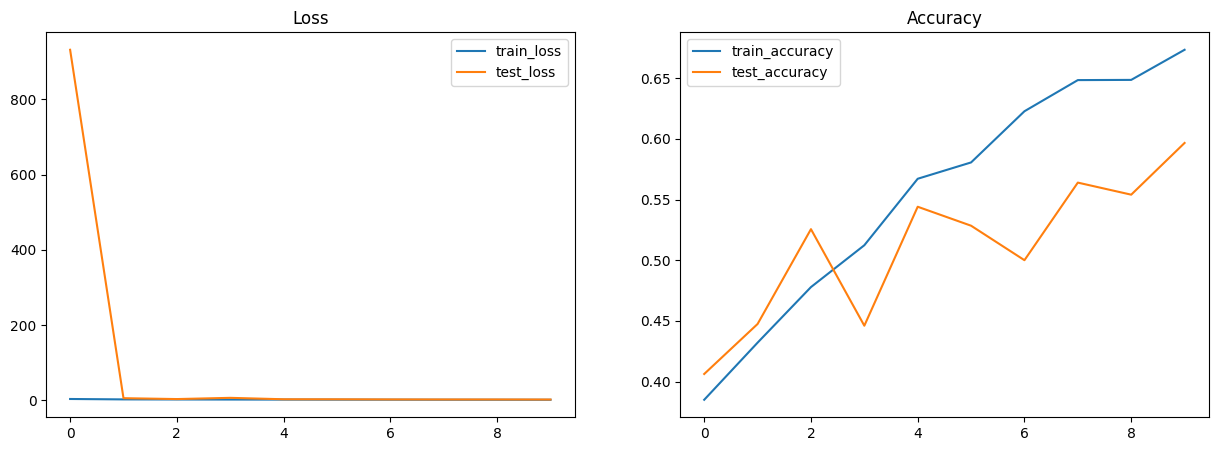

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

# 12. Perform inference on test set

In [24]:
@jax.jit
def pred_step(state: TrainState, batch):
    """Train for a single step."""
    logits = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        x=batch['image'], 
        training=False)
    return jnp.argmax(logits, -1)

pred_list = []
for step, batch in enumerate(test_ds):
    pred = pred_step(state, batch)
    pred_list.append(pred)

type(pred_list[0])

jaxlib.xla_extension.ArrayImpl